In [1]:
import os
from pathlib import Path

PHENOTYPE_FOLDER = Path("/local/scratch/carlyn.1/dna/colors/processed")
GENOME_FOLDER = Path("/local/scratch/carlyn.1/dna/vcfs/processed/genome")
DATA_SPLIT_FOLDER = Path("/home/carlyn.1/dna-trait-analysis/data")
RESULTS_FOLDER = Path("/local/scratch/carlyn.1/dna/results/whole_genome_pval/")
PLOT_RESULTS_FOLDER = Path("/home/carlyn.1/dna-trait-analysis/plot_results")
BATCH_SIZE = 16
DEVICES = "6"
REDO = False

os.environ["CUDA_VISIBLE_DEVICES"]=DEVICES
ex_path = "/local/scratch/carlyn.1/dna/results/whole_genome/erato_forewings_color_3_chromosome_18"



In [2]:
import os
import json

import pandas as pd
import numpy as np
import torch

from scipy.stats import pearsonr
from captum.attr import GuidedGradCam

from gtp.evaluation import get_lrp_attr
from gtp.dataloading.tools import (
    load_chromosome_data,
    split_data_by_file,
)

def load_data(phenotype_folder, genome_folder, split_data_folder, chromosome, species, wing, color, out_dims_start_idx=0, out_dims=1):
    camids_aligned, genotype_data_aligned, phenotype_data_aligned = (
        load_chromosome_data(
            genome_folder,
            phenotype_folder,
            species,
            wing,
            color,
            chromosome,
        )
    )

    phenotype_data_aligned = phenotype_data_aligned[
        :, out_dims_start_idx : out_dims_start_idx + out_dims
    ]

    train_split, val_split, test_split = split_data_by_file(
        genotype_data_aligned,
        phenotype_data_aligned,
        camids_aligned,
        split_data_folder,
        species,
    )

    return train_split, val_split, test_split

def calc_pearson_correlation(model, dloader, index=0):
    model.eval()
    actual = []
    predicted = []
    for i, batch in enumerate(dloader):
        model.zero_grad()
        data, pca = batch
        out = model(data.cuda())
        actual.extend(pca[:, index].detach().cpu().numpy().tolist())
        predicted.extend(out[:, index].detach().cpu().numpy().tolist())
    return pearsonr(predicted, actual)

def compile_attribution(attr):
    attr, _ = torch.abs(attr).max(-1)
    attr = attr[:, 0] # Only has 1 channel, just extract it
    attr = attr.detach().cpu().numpy()
    attr = np.median(np.abs(attr), 0) # median across batch???
    #attr = attr.sum(0) # Sum across batch...Should we be summing here???
    return attr

def get_saliency_attr(m, dloader, target=0):
    att_model = GuidedGradCam(m, m.last_block)
    attr_total = None
    for i, batch in enumerate(dloader):
        m.zero_grad()
        data, pca = batch
        attr = att_model.attribute(data.cuda(), target=target)
        attr = compile_attribution(attr)
        if attr_total is None:
            attr_total = attr
        else:
            attr_total += attr

    #attr_total = attr_total / np.linalg.norm(attr_total, ord=1) # Normalize
    return attr_total

def load_json_attributes(path):
    with open(path, 'r') as f:
        return json.load(f)
    
def save_json_attributes(path, data):
    with open(path, 'w') as f:
        json.dump(data, f)

In [3]:
import os

import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

from gtp.dataloading.datasets import GTP_Dataset
from gtp.models.net import SoyBeanNet

def compute_and_save_data(species, wing, color, results_dir, num_chromosome=21, target_index=0, skip_loading=False):
    os.makedirs(results_dir, exist_ok=True)
    chromo_results = []
    chromo_pvals = []
    attributions = []

    if REDO or not os.path.exists(os.path.join(results_dir, "chromosome_summary_pearson.npy")):
        for chromosome in tqdm(range(1, num_chromosome+1), "Extracting Chromosome Results"):
            train_data, val_data, test_data = load_data(PHENOTYPE_FOLDER, GENOME_FOLDER, DATA_SPLIT_FOLDER, 
                    chromosome, species, wing, color, out_dims_start_idx=0, out_dims=1)

            train_dataset = GTP_Dataset(*train_data)
            val_dataset = GTP_Dataset(*val_data)
            test_dataset = GTP_Dataset(*test_data)

            num_vcfs = train_data[0].shape[1]

            train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
            val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)
            test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)

            model = SoyBeanNet(window_size=num_vcfs, num_out_dims=1, insize=3, hidden_dim=10, drop_out_prob=0.75)
            model_path = RESULTS_FOLDER / Path(f"{species}_{wing}_{color}_chromosome_{chromosome}/model.pt")
            model.load_state_dict(torch.load(model_path))
            model = model.cuda()
            model.eval()

            with torch.no_grad():
                #tr_pearson_stat, _ = calc_pearson_correlation(model, train_dataloader, DEVICE)
                val_pearson_stat, val_pv = calc_pearson_correlation(model, val_dataloader)
                test_pearson_stat, test_pv = calc_pearson_correlation(model, test_dataloader)
            #val_att = get_saliency_attr(model, val_dataloader, DEVICE, target=target_index)
            #test_att = get_saliency_attr(model, test_dataloader, DEVICE, target=target_index)
            val_att = get_lrp_attr(model, val_dataloader, target=target_index)
            test_att = get_lrp_attr(model, test_dataloader, target=target_index)
            attributions.append([val_att.tolist(), test_att.tolist()])
            chromo_results.append([val_pearson_stat, test_pearson_stat])
            chromo_pvals.append([f"{val_pv:.2e}", f"{test_pv:.2e}"])
            
            print(f"Chromosome: {chromosome} - Pearson | (val) {val_pearson_stat} ({val_pv:.2e}) | (test) {test_pearson_stat} ({test_pv:.2e})")
            
        np.save(os.path.join(results_dir, "chromosome_summary_pearson.npy"), chromo_results)
        np.save(os.path.join(results_dir, "chromosome_summary_pvals.npy"), chromo_pvals)
        save_json_attributes(os.path.join(results_dir, "chromosome_attributions.json"), attributions)
    else:
        if skip_loading:
            return None, None, None
        chromo_results = np.load(os.path.join(results_dir, "chromosome_summary_pearson.npy"))
        chromo_pvals = np.load(os.path.join(results_dir, "chromosome_summary_pvals.npy"))
        attributions = load_json_attributes(os.path.join(results_dir, "chromosome_attributions.json"))
        
    return chromo_results, chromo_pvals, attributions

In [4]:
target_index = 0
num_chromosome = 21

for species in ["erato", "melpomene"]:
    for wing in ["forewings"]:
        for color in ["color_1", "color_2", "color_3", "total"]:
            print(f"Calculating attributions for: {species}-{wing}-{color}")
            results_dir = PLOT_RESULTS_FOLDER / f"pvalue_{species}_{wing}_{color}"
            chromo_results, chromo_pvals, attributions = compute_and_save_data(species, wing, color, results_dir, num_chromosome=num_chromosome, target_index=target_index, skip_loading=True)


Calculating attributions for: erato-forewings-color_3
Calculating attributions for: erato-forewings-total
Calculating attributions for: melpomene-forewings-color_3


Extracting Chromosome Results:   0%|          | 0/21 [00:00<?, ?it/s]/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:   5%|▍         | 1/21 [00:34<11:30, 34.50s/it]

Chromosome: 1 - Pearson | (val) 0.843260694167453 (1.11e-05) | (test) 0.7745857791993381 (6.09e-05)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  10%|▉         | 2/21 [01:03<09:58, 31.52s/it]

Chromosome: 2 - Pearson | (val) 0.7880497238634225 (1.03e-04) | (test) 0.8768305951772732 (3.93e-07)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  14%|█▍        | 3/21 [01:34<09:19, 31.06s/it]

Chromosome: 3 - Pearson | (val) 0.867352901061111 (3.15e-06) | (test) 0.830496247018915 (5.83e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  19%|█▉        | 4/21 [02:04<08:37, 30.47s/it]

Chromosome: 4 - Pearson | (val) 0.8720175068189094 (2.40e-06) | (test) 0.8316005950582863 (5.52e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  24%|██▍       | 5/21 [02:35<08:14, 30.91s/it]

Chromosome: 5 - Pearson | (val) 0.6828344884760144 (1.79e-03) | (test) 0.8893872140262552 (1.57e-07)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  29%|██▊       | 6/21 [03:05<07:39, 30.60s/it]

Chromosome: 6 - Pearson | (val) 0.7942390130932515 (8.28e-05) | (test) 0.8538166746093054 (1.68e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  33%|███▎      | 7/21 [03:35<07:05, 30.39s/it]

Chromosome: 7 - Pearson | (val) 0.7798583011784216 (1.35e-04) | (test) 0.8582163332498951 (1.30e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  38%|███▊      | 8/21 [04:02<06:21, 29.34s/it]

Chromosome: 8 - Pearson | (val) 0.7990428775187978 (6.96e-05) | (test) 0.8429103674925147 (3.08e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  43%|████▎     | 9/21 [04:32<05:52, 29.41s/it]

Chromosome: 9 - Pearson | (val) 0.676488170731944 (2.05e-03) | (test) 0.8449847082662866 (2.76e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  48%|████▊     | 10/21 [05:02<05:24, 29.52s/it]

Chromosome: 10 - Pearson | (val) 0.8309706763799578 (1.94e-05) | (test) 0.8739613559140702 (4.78e-07)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  52%|█████▏    | 11/21 [05:30<04:53, 29.32s/it]

Chromosome: 11 - Pearson | (val) 0.799742072075818 (6.79e-05) | (test) 0.751799365460263 (1.32e-04)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  57%|█████▋    | 12/21 [06:01<04:28, 29.82s/it]

Chromosome: 12 - Pearson | (val) 0.7927338720063555 (8.73e-05) | (test) 0.8661932551243637 (7.95e-07)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  62%|██████▏   | 13/21 [06:33<04:03, 30.47s/it]

Chromosome: 13 - Pearson | (val) 0.8787761159732543 (1.59e-06) | (test) 0.8121820874600956 (1.37e-05)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  67%|██████▋   | 14/21 [07:01<03:28, 29.72s/it]

Chromosome: 14 - Pearson | (val) 0.8831391884574322 (1.20e-06) | (test) 0.7836193054792304 (4.37e-05)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  71%|███████▏  | 15/21 [07:30<02:55, 29.30s/it]

Chromosome: 15 - Pearson | (val) 0.8904977654158586 (7.33e-07) | (test) 0.8913054918121839 (1.35e-07)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  76%|███████▌  | 16/21 [07:59<02:26, 29.29s/it]

Chromosome: 16 - Pearson | (val) 0.8943965453321057 (5.56e-07) | (test) 0.7577917579143245 (1.09e-04)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  81%|████████  | 17/21 [08:29<01:57, 29.47s/it]

Chromosome: 17 - Pearson | (val) 0.8438214004832406 (1.08e-05) | (test) 0.8173281017701303 (1.09e-05)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  86%|████████▌ | 18/21 [09:00<01:30, 30.02s/it]

Chromosome: 18 - Pearson | (val) 0.9749939027545879 (7.11e-12) | (test) 0.944854915123519 (3.66e-10)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  90%|█████████ | 19/21 [09:32<01:01, 30.53s/it]

Chromosome: 19 - Pearson | (val) 0.8563858807422523 (5.74e-06) | (test) 0.7597998851057048 (1.02e-04)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  95%|█████████▌| 20/21 [10:03<00:30, 30.66s/it]

Chromosome: 20 - Pearson | (val) 0.8359558865945225 (1.55e-05) | (test) 0.8520716907271999 (1.86e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results: 100%|██████████| 21/21 [10:34<00:00, 30.23s/it]

Chromosome: 21 - Pearson | (val) 0.7761506600460307 (1.53e-04) | (test) 0.8146435940724979 (1.22e-05)


Calculating attributions for: melpomene-forewings-total


Extracting Chromosome Results:   0%|          | 0/21 [00:00<?, ?it/s]/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:   5%|▍         | 1/21 [00:28<09:24, 28.22s/it]

Chromosome: 1 - Pearson | (val) 0.8634157474454663 (3.93e-06) | (test) 0.7783073482941818 (5.32e-05)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  10%|▉         | 2/21 [00:51<08:02, 25.42s/it]

Chromosome: 2 - Pearson | (val) 0.8195780290722039 (3.15e-05) | (test) 0.8993251642386337 (6.97e-08)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  14%|█▍        | 3/21 [01:15<07:27, 24.84s/it]

Chromosome: 3 - Pearson | (val) 0.8725511574018272 (2.33e-06) | (test) 0.839627992772536 (3.67e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  19%|█▉        | 4/21 [01:39<06:51, 24.20s/it]

Chromosome: 4 - Pearson | (val) 0.8724417045017258 (2.34e-06) | (test) 0.8639536112057129 (9.16e-07)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  24%|██▍       | 5/21 [02:06<06:46, 25.42s/it]

Chromosome: 5 - Pearson | (val) 0.7121511591262703 (9.14e-04) | (test) 0.81981166253741 (9.69e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  29%|██▊       | 6/21 [02:33<06:29, 25.96s/it]

Chromosome: 6 - Pearson | (val) 0.8181329438663971 (3.34e-05) | (test) 0.86453447021391 (8.83e-07)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  33%|███▎      | 7/21 [02:58<05:57, 25.55s/it]

Chromosome: 7 - Pearson | (val) 0.7154556867713981 (8.43e-04) | (test) 0.8636943382551572 (9.31e-07)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  38%|███▊      | 8/21 [03:23<05:29, 25.34s/it]

Chromosome: 8 - Pearson | (val) 0.7852258542351485 (1.13e-04) | (test) 0.7884036188003618 (3.64e-05)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  43%|████▎     | 9/21 [03:47<05:00, 25.07s/it]

Chromosome: 9 - Pearson | (val) 0.6831513514140017 (1.78e-03) | (test) 0.9006541300245028 (6.21e-08)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  48%|████▊     | 10/21 [04:14<04:40, 25.53s/it]

Chromosome: 10 - Pearson | (val) 0.8977845597164933 (4.33e-07) | (test) 0.9106596254513994 (2.48e-08)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  52%|█████▏    | 11/21 [04:41<04:21, 26.18s/it]

Chromosome: 11 - Pearson | (val) 0.8357658208748794 (1.57e-05) | (test) 0.7626142762305169 (9.25e-05)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  57%|█████▋    | 12/21 [05:08<03:56, 26.32s/it]

Chromosome: 12 - Pearson | (val) 0.8101844892016838 (4.58e-05) | (test) 0.8935450476298739 (1.13e-07)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  62%|██████▏   | 13/21 [05:36<03:34, 26.77s/it]

Chromosome: 13 - Pearson | (val) 0.8744345871744217 (2.08e-06) | (test) 0.903943196751781 (4.65e-08)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  67%|██████▋   | 14/21 [06:02<03:05, 26.54s/it]

Chromosome: 14 - Pearson | (val) 0.8719751259521169 (2.41e-06) | (test) 0.792176448964333 (3.14e-05)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  71%|███████▏  | 15/21 [06:27<02:37, 26.25s/it]

Chromosome: 15 - Pearson | (val) 0.895387261120923 (5.17e-07) | (test) 0.8545209573924386 (1.61e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  76%|███████▌  | 16/21 [06:52<02:08, 25.79s/it]

Chromosome: 16 - Pearson | (val) 0.9175764163180044 (8.25e-08) | (test) 0.7933512986827458 (3.00e-05)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  81%|████████  | 17/21 [07:19<01:44, 26.07s/it]

Chromosome: 17 - Pearson | (val) 0.8551385647306808 (6.13e-06) | (test) 0.7487964703774066 (1.46e-04)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  86%|████████▌ | 18/21 [07:47<01:19, 26.59s/it]

Chromosome: 18 - Pearson | (val) 0.9574244986468452 (4.75e-10) | (test) 0.9477707378433395 (2.27e-10)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  90%|█████████ | 19/21 [08:14<00:53, 26.85s/it]

Chromosome: 19 - Pearson | (val) 0.86560786116393 (3.48e-06) | (test) 0.9076256580918092 (3.31e-08)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  95%|█████████▌| 20/21 [08:42<00:27, 27.22s/it]

Chromosome: 20 - Pearson | (val) 0.8324575814857005 (1.82e-05) | (test) 0.8327415771943344 (5.21e-06)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results: 100%|██████████| 21/21 [09:08<00:00, 26.13s/it]

Chromosome: 21 - Pearson | (val) 0.8045563419544274 (5.68e-05) | (test) 0.8050490333923781 (1.86e-05)


In [5]:
species = "erato"
wing = "forewings"
color = "total"
results_dir = PLOT_RESULTS_FOLDER / f"pvalue_{species}_{wing}_{color}"

chromo_results = np.load(os.path.join(results_dir, "chromosome_summary_pearson.npy"))
chromo_pvals = np.load(os.path.join(results_dir, "chromosome_summary_pvals.npy"))
attributions = load_json_attributes(os.path.join(results_dir, "chromosome_attributions.json"))

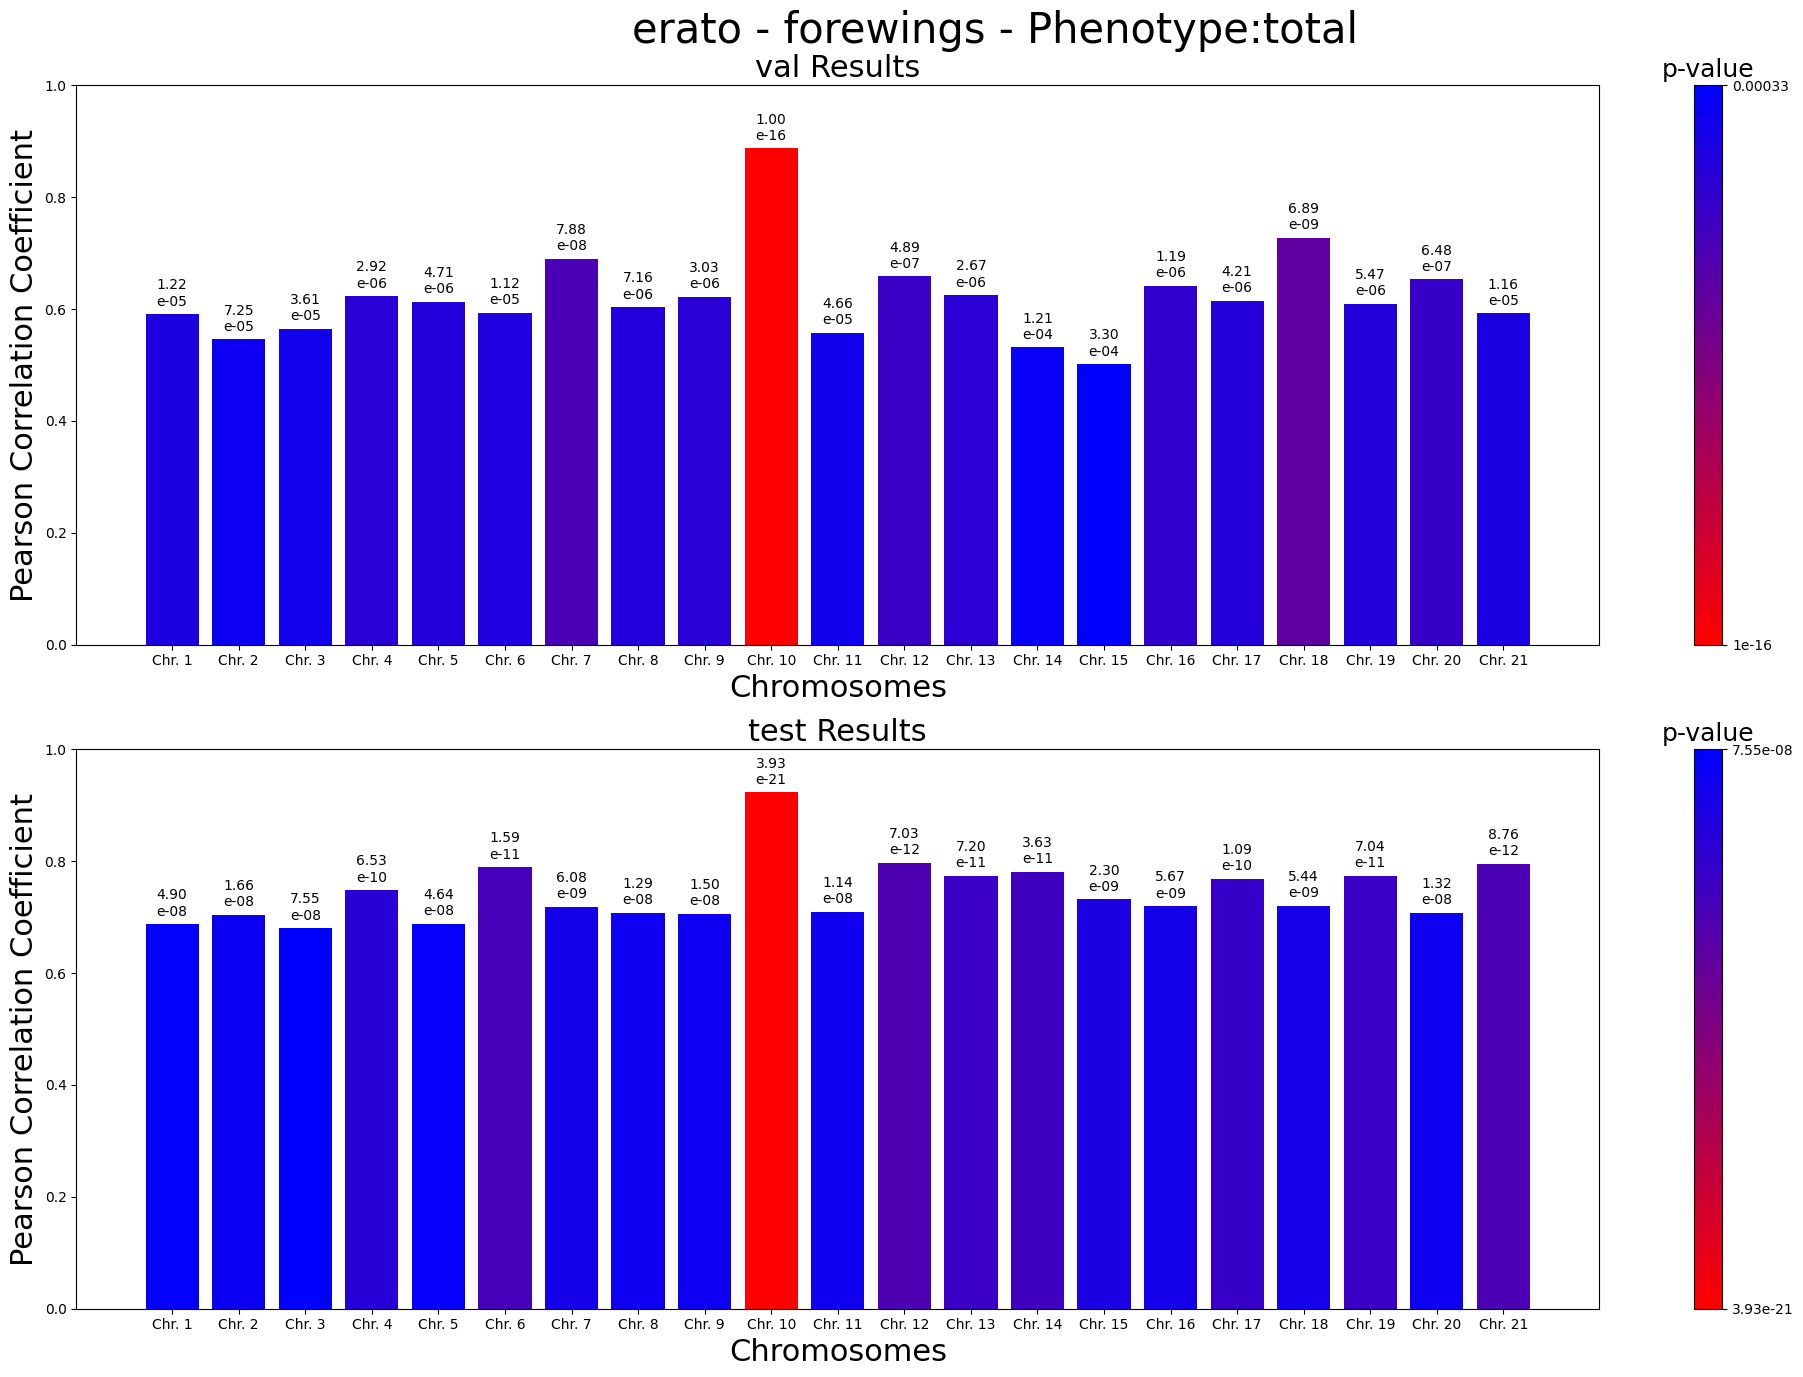

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

bar_colors = [
    (1, 0, 0),
    (0, 0, 1)
] # go from red to blue (significant to least significant)

pos = [0.0, 1.0]
bar_cmap = LinearSegmentedColormap.from_list('custom_colormap', 
                                                list(zip(pos, bar_colors)))

fig, axs = plt.subplots(2, 1, figsize=(20, 14))
fig.suptitle(f"{species} - {wing} - Phenotype:{color}", fontsize=30)

chromo_results = np.array(chromo_results)
chromo_pvals = np.array(chromo_pvals)
chromo_labels = [f"Chr. {chr}" for chr in range(1, num_chromosome+1)]

for pi, phase in enumerate(["val", "test"]):

    val_list = chromo_pvals[:, pi].astype(np.float64)
    normed_vals = LogNorm()(val_list)
    cur_colors = [bar_cmap(pv) for pv in normed_vals]
    bar_plots = axs[pi].bar(chromo_labels, chromo_results[:, pi], color=cur_colors)
    axs[pi].set_title(f"{phase} Results", fontsize=22)
    axs[pi].set_ylim([0, 1])
    axs[pi].set_xlabel("Chromosomes", fontsize=22)
    axs[pi].set_ylabel("Pearson Correlation Coefficient", fontsize=22)

    rects = axs[pi].patches

    for rect, label in zip(rects, chromo_pvals[:, pi]):
        label = "\ne".join(label.split("e"))
        height = rect.get_height()
        axs[pi].text(
            rect.get_x() + rect.get_width() / 2, height + 0.01, 
            label, ha="center", va="bottom", rotation=0
        )
        
    cbar = fig.colorbar(None, ax=axs[pi], cmap=bar_cmap)
    cbar.ax.set_title("p-value", fontsize=18)
    cbar.ax.get_yaxis().set_ticks([1.0, 0.0])
    cbar.ax.get_yaxis().set_ticklabels([val_list.max(), val_list.min()])

fig.tight_layout()

plt.savefig(os.path.join(results_dir / f"genome_summary_{species}_{wing}_{color}.png"))
plt.show()


Plotting Attributions:   5%|▍         | 1/21 [00:04<01:22,  4.10s/it]

Plotting Attributions: 100%|██████████| 21/21 [01:13<00:00,  3.49s/it]


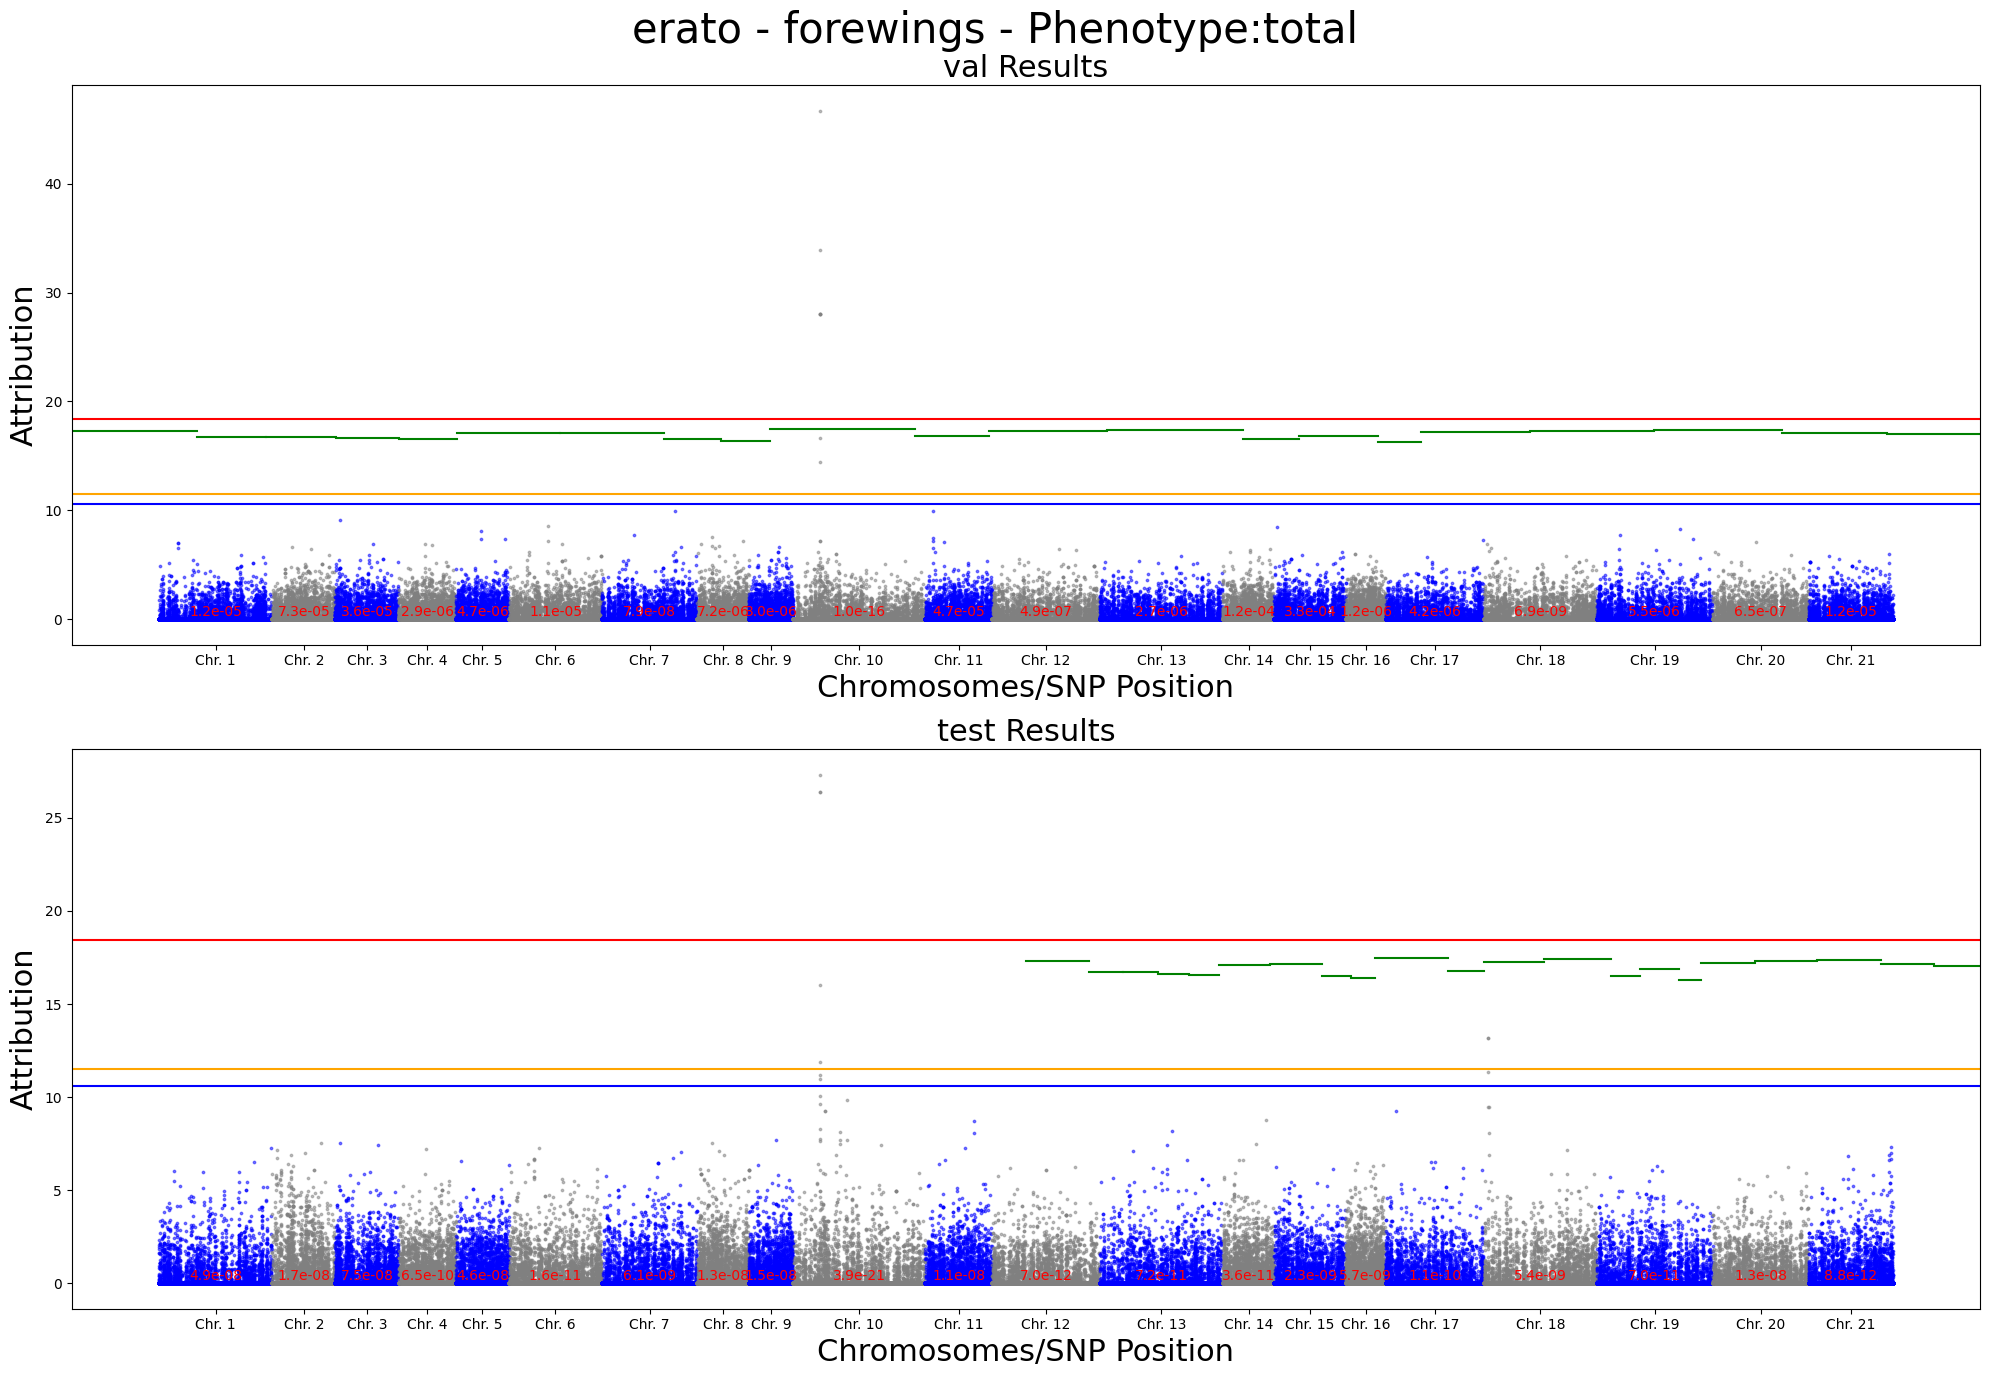

In [8]:
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from gtp.tools import calc_pvalue_linear, filter_topk_snps, profile_exe_time

bar_colors = [
    (1, 0, 0),
    (0, 0, 1)
] # go from red to blue (significant to least significant)

pos = [0.0, 1.0]
bar_cmap = LinearSegmentedColormap.from_list('custom_colormap', 
                                                list(zip(pos, bar_colors)))

fig, axs = plt.subplots(2, 1, figsize=(20, 14))
fig.suptitle(f"{species} - {wing} - Phenotype:{color}", fontsize=30)

chromo_labels = [f"Chr. {chr}" for chr in range(1, num_chromosome+1)]

alt_colors = ["blue", "grey"]
for pi, phase in enumerate(["val", "test"]):
    start_pos = 0
    chromo_pvals = np.array(chromo_pvals)
    p_values = chromo_pvals[:, pi].astype(np.float64)
    p_values_normalized = (p_values - p_values.min()) / (p_values.max() - p_values.min())
    p_values_normalized = 1 - p_values_normalized
    x_mid_points = []
    sig_lines = []
    for ci in tqdm(range(num_chromosome), desc="Plotting Attributions"):
        dset = _, val_data, test_data = load_data(PHENOTYPE_FOLDER, GENOME_FOLDER, DATA_SPLIT_FOLDER, 
            ci+1, species, wing, color, out_dims_start_idx=0, out_dims=1)
        chromo_data = np.array(attributions[ci][pi])
        num_pos = chromo_data.shape[0]
        X = np.arange(num_pos) + start_pos
        
        top_k_idx = filter_topk_snps(chromo_data, k=2000)
        
        dset = None
        if phase == "val":
            dset = GTP_Dataset(*val_data)
        elif phase == "test":
            dset = GTP_Dataset(*test_data)
        
        pvals = calc_pvalue_linear(
            np.take(dset.genotype_data, indices=top_k_idx, axis=1),
            dset.phenotype_data[:, 0],
        )
        all_pvals = np.ones(num_pos)
        all_pvals[top_k_idx] = pvals
        
        sig_lines.append([start_pos, X[-1], -np.log(0.05/num_pos)])
        
        #adjust_val = p_values_normalized[ci]
        #Y = chromo_data
        Y = -np.log(all_pvals)
        start_pos = X[-1]
        bar_plots = axs[pi].scatter(X, Y, alpha=0.5, s=3, color=alt_colors[ci % 2 == 1])
        axs[pi].set_title(f"{phase} Results", fontsize=22)
        axs[pi].set_xlabel("Chromosomes/SNP Position", fontsize=22)
        axs[pi].set_ylabel("Attribution", fontsize=22)
        #axs[pi].axhline(y=-np.log(0.05 / num_pos), color="green")
        mid_point = X[X.shape[0]//2]
        x_mid_points.append(mid_point)
        axs[pi].text(
            mid_point, 0, 
            f"{p_values[ci]:.1e}", ha="center", va="bottom", rotation=0, color="red"
        )
        
    #for s, e, y in sig_lines:
    #    axs[pi].axhline(y=y, xmin=s/start_pos, xmax=e/start_pos, color='green')
    axs[pi].set_xticks(x_mid_points)
    axs[pi].set_xticklabels(chromo_labels)
    axs[pi].axhline(y=-np.log(1e-8), color="red")
    axs[pi].axhline(y=-np.log(1e-5), color="orange")
    axs[pi].axhline(y=-np.log(0.05 / 2000), color="blue")

fig.tight_layout()

plt.savefig(os.path.join(results_dir, f"genome_detail_{species}_{wing}_{color}.png"))
plt.show()
        
    

/tmp/ipykernel_1091874/282410606.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PuBu_r')


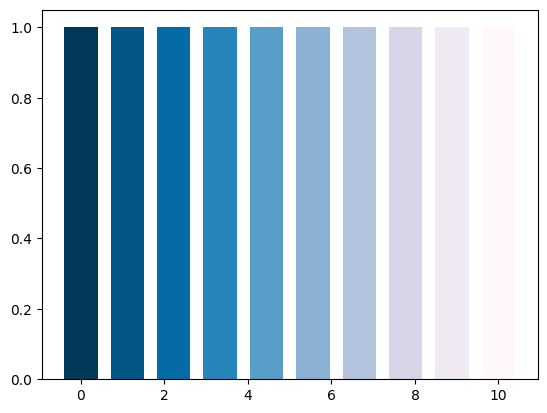

"\n# A low hump with a spike coming out of the top right.  Needs to have\n# z/colour axis on a log scale, so we see both hump and spike. A linear\n# scale only shows the spike.\nZ1 = np.exp(-X**2 - Y**2)\nZ2 = np.exp(-(X * 10)**2 - (Y * 10)**2)\nZ = Z1 + 50 * Z2\n\nfig, ax = plt.subplots(2, 1)\n\npcm = ax[0].pcolor(X, Y, Z,\n                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),\n                   cmap='PuBu_r', shading='auto')\nfig.colorbar(pcm, ax=ax[0], extend='max')\n\npcm = ax[1].pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')\nfig.colorbar(pcm, ax=ax[1], extend='max')\nplt.show()\n"

In [7]:
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

cmap = cm.get_cmap('PuBu_r')
log_norm = colors.LogNorm()

X = np.linspace(0, 10, 10)
Y = np.logspace(0, 1e-6, 10, base=1e-20)[::-1]

fig, ax = plt.subplots(1, 1)
ax.bar(X, Y, color=cmap(log_norm(Y)))
plt.show()


"""
# A low hump with a spike coming out of the top right.  Needs to have
# z/colour axis on a log scale, so we see both hump and spike. A linear
# scale only shows the spike.
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
Z = Z1 + 50 * Z2

fig, ax = plt.subplots(2, 1)

pcm = ax[0].pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=ax[0], extend='max')

pcm = ax[1].pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=ax[1], extend='max')
plt.show()
"""